<a href="https://colab.research.google.com/github/alecd1014/Alec_INFO5731_Spring2025/blob/main/Duray_Alec_Assignment_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment: 4**

**This exercise will provide a valuable learning experience in working with text data and extracting features using various topic modeling algorithms. Key concepts such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) and BERTopic.**



**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 100


NOTE: The output should be presented well to get **full points**

**Late submissions will have a penalty of 10% of the marks for each day of late submission, and no requests will be answered. Manage your time accordingly.**


# **Question 1 (20 Points)**

**Dataset**: 20 Newsgroups dataset

**Dataset Link**: https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html

**Consider Random 2000 rows only**

Generate K=10 topics by using LDA and LSA,
then calculate coherence score and determine the optimized K value by the coherence score. Further, summarize and visualize each topics in you own words.


In [1]:
!pip install gensim pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 71.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 17.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [6]:
!pip install --upgrade gensim --force-reinstall

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
  Using cached smart_open-7.1.0-py3-none-any.whl.metadata (24 kB)
  Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.4 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
Using cached scipy-1.13.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (38.6 MB)
Using cached smart_open-7.1.0-py3-none-any.whl (61 kB)
Using cached wrapt-1.17.2-cp311-cp311-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (83 kB)
  Att

In [1]:
import random
import nltk
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
from wordcloud import WordCloud

#download the stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
#load the newsgroups data, also removed headers, footers, and quotes
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
#get a random sample of 2000 rows
random = random.sample(newsgroups_data.data, 2000)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#starting with some text preprocessing
stop_words = stopwords.words('english')
#write function to make text lowercase and to remove stopwords
def preprocess(text):
  return ' '.join([word for word in text.lower().split() if word.isalpha() and word not in stop_words])

cleaned_text = [preprocess(words) for words in random]
#perform the vectorization on the cleaned text
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
term_matrix = vectorizer.fit_transform(cleaned_text)
terms = vectorizer.get_feature_names_out()
#create a dictionary and corpus which Gensim can use
dictionary = corpora.Dictionary([doc.split() for doc in cleaned_text])
corpus = [dictionary.doc2bow(doc.split()) for doc in cleaned_text]

In [3]:
#create a function to calculate the coherence
def calc_coherence(model_type='lda', texts=None, start=2, limit=15, step=1):
  coherence_values = []
  models = []
  for x in range(start, limit, step):
    #check which model type is going to be used
    if model_type == 'lda':
      model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=x, passes=10, random_state=42)
    elif model_type == 'lsa':
      model = TruncatedSVD(n_components=x, random_state=42)
      model.fit(term_matrix)
    else:
      continue
    #build the coherence model for the LDA model type
    if model_type == 'lda':
      coherence_model = CoherenceModel(model=model, texts=[doc.split() for doc in cleaned_text],
                                       dictionary=dictionary, coherence='c_v')
    else:
      #build the coherence model for the LSA model type
      topics = []
      for topic in model.components_:
        top_words = topic.argsort()[-10:][::-1]
        topics.append([terms[i] for i in top_words])
      coherence_model = CoherenceModel(topics=topics, texts=[doc.split() for doc in cleaned_text],
                                       dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
    models.append(model)
  return models, coherence_values

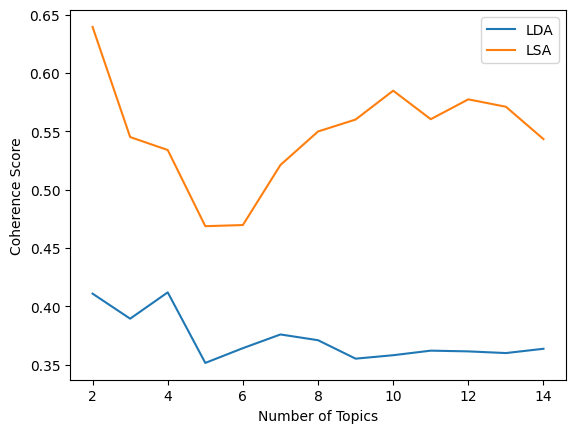

Best K for LDA: 4
Best K for LSA: 2


In [4]:
#now to find the best K using the coherence scores
lda_models, lda_coherence = calc_coherence(model_type='lda', texts=cleaned_text)
lsa_models, lsa_coherence = calc_coherence(model_type='lsa', texts=cleaned_text)
#plot the coherence scores
x = list(range(2, 15))
plt.plot(x, lda_coherence, label='LDA')
plt.plot(x, lsa_coherence, label='LSA')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.legend()
plt.show()
#calculated the best K
best_lda_k = x[lda_coherence.index(max(lda_coherence))]
best_lsa_k = x[lsa_coherence.index(max(lsa_coherence))]

print(f"Best K for LDA: {best_lda_k}")
print(f"Best K for LSA: {best_lsa_k}")


LDA Topics:
Topic 1: people one would many also like god time think know


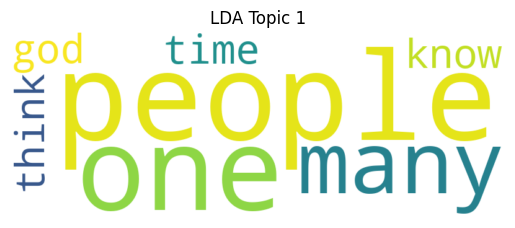

Topic 2: would one get like use know may also could even


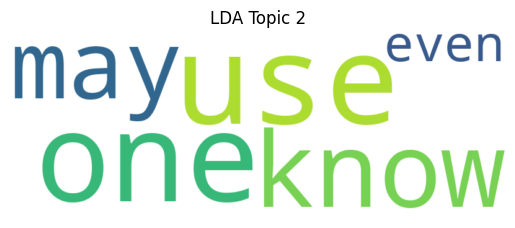

Topic 3: q would one think president armenian people going know also


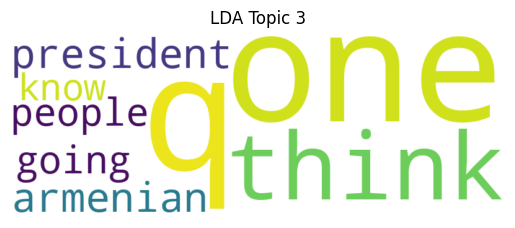

Topic 4: would get like one know anyone use windows think new


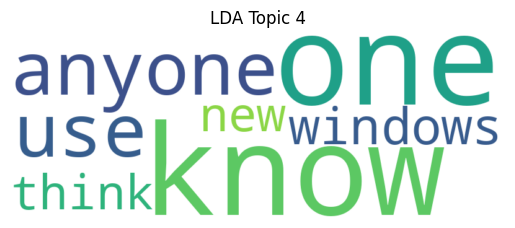


LSA Topics:
Topic 1: president know going think people said solar like spacecraft make


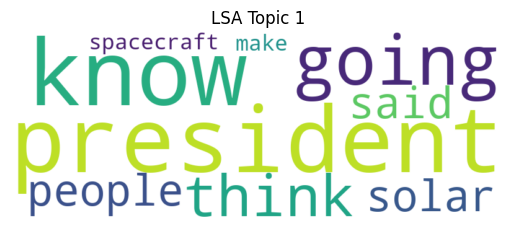

Topic 2: solar spacecraft surface earth moon atmosphere planet degrees venus mariner


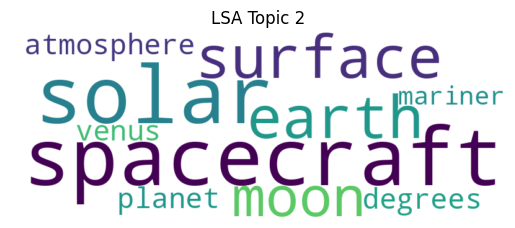

In [5]:
#Finally, to visualize and summarize the topics
#LDA topics
lda_model = lda_models[lda_coherence.index(max(lda_coherence))]
print("\nLDA Topics:")
#use a word cloud to visualize the best 10 topics
for i, topic in lda_model.show_topics(formatted=False, num_words=10):
  words = [word for word, prob in topic]
  print(f"Topic {i+1}: {' '.join(words)}")
  word_cloud = WordCloud(width=800, height=300, background_color='white').generate(' '.join(words))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"LDA Topic {i+1}")
  plt.show()

#LSA topics same as LDA topics
lsa_model = lsa_models[lsa_coherence.index(max(lsa_coherence))]
print("\nLSA Topics:")
#as above, use a word cloud to visualize the best topics based the LDA model
for i, topic in enumerate(lsa_model.components_):
  words = [terms[i] for i in topic.argsort()[:-11:-1]]
  print(f"Topic {i+1}: {' '.join(words)}")
  word_cloud = WordCloud(width=800, height=300, background_color='white').generate(' '.join(words))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f"LSA Topic {i+1}")
  plt.show()
#After looking the wordclouds generated from both the LDA topics and the LSA topics,
#there seems to be some overlap between some of the LDA topics. Since there are only 2
#LSA topics there is not as much overlap, and therefore this method might be a better way
#to analyze these items than the LDA method. However, if a different model other than a world cloud
#is used then it might become more clear what the best topics are.

# **BERTopic**

The following question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents.

Dataset from **assignment-3** (text dataset) .

> Dont use any custom datasets.


> Dataset must have 1000+ rows, no duplicates and null values



# **Question 2 (20 Points)**



Q2) **Generate K=10 topics by using BERTopic and then find optimal K value by the coherence score. Interpret each topic and visualize with suitable style.**

In [7]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 867.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 39.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [14]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import matplotlib.pyplot as plt

#First we load the dataset which will be used
df = pd.read_csv('Clean_Narrators.csv')
#make sure that there are no null values and convert to a list
clean = df['Clean data'].dropna().tolist()
#initialize the BERTopic
topic_model = BERTopic(language='english')
#fit the model
topics, probs = topic_model.fit_transform(clean)
#reduce the topics to K=10
topic_model.reduce_topics(clean, nr_topics=10)
#finally, show the reduced topics
print(topic_model.get_topic_info())
topic_model.visualize_topics()

   Topic  Count                                 Name  \
0     -1    189        -1_california_born_male_nisei   
1      0    371             0_nisei_born_grew_oregon   
2      1    163       1_washington_seattl_nisei_born   
3      2     79           2_lo_angel_california_grew   
4      3     71    3_sansei_california_camp_concentr   
5      4     50             4_serv_camp_militari_war   
6      5     26         5_interview_bill_tashima_led   
7      6     22  6_white_arkansa_director_california   
8      7     13         7_redress_movement_os_justic   
9      8     12     8_termin_island_fisherman_father   

                                      Representation  \
0  [california, born, male, nisei, grew, world, i...   
1  [nisei, born, grew, oregon, california, femal,...   
2  [washington, seattl, nisei, born, femal, puyal...   
3  [lo, angel, california, grew, nisei, born, war...   
4  [sansei, california, camp, concentr, born, par...   
5  [serv, camp, militari, war, ii, world, nisei

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



K=5, Coherence Score=0.6808
K=6, Coherence Score=0.6705
K=7, Coherence Score=0.6457
K=8, Coherence Score=0.6221
K=9, Coherence Score=0.5863
K=10, Coherence Score=0.6122
K=11, Coherence Score=0.6036
K=12, Coherence Score=0.5968
K=13, Coherence Score=0.6027
K=14, Coherence Score=0.6039
K=15, Coherence Score=0.6247
K=16, Coherence Score=0.5965
K=17, Coherence Score=0.6304
K=18, Coherence Score=0.6111
K=19, Coherence Score=0.6257
K=20, Coherence Score=0.6256


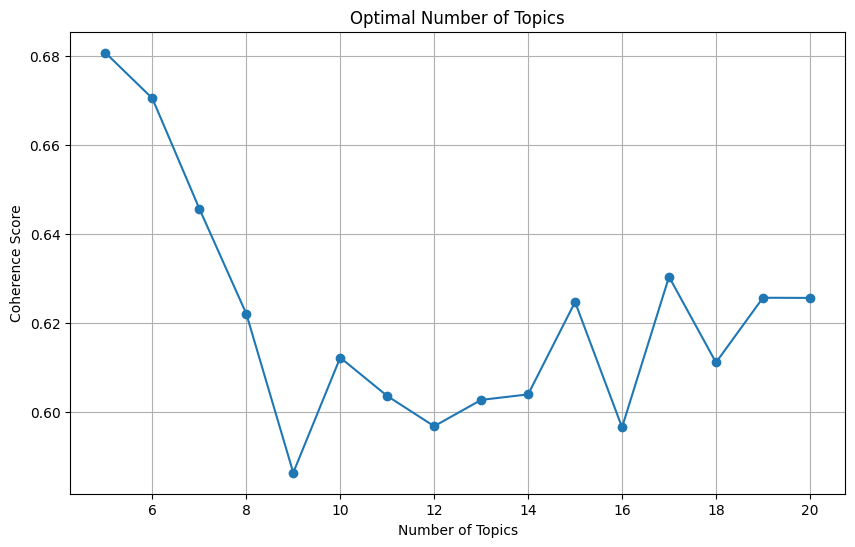

In [15]:
#write a function to evaluate the coherence
def evaluate_coherence(clean, k_range):
    coherence_scores = []
    for k in k_range:
        model = BERTopic(language='english')
        topics, _ = model.fit_transform(clean)
        model.reduce_topics(clean, nr_topics=k)

        topic_words = [[word for word, _ in model.get_topic(topic)] for topic in range(k)
                        if isinstance(model.get_topic(topic), list)]

        #prepare and use coherence model
        tokenized_texts = [text.split() for text in clean]
        dictionary = Dictionary(tokenized_texts)
        corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

        coherence_model = CoherenceModel(topics=topic_words,
                                         texts=tokenized_texts,
                                         dictionary=dictionary,
                                         coherence='c_v')
        score = coherence_model.get_coherence()
        coherence_scores.append(score)
        print(f"K={k}, Coherence Score={score:.4f}")

    return coherence_scores

#create a range of k values to try
k_values = list(range(5, 21))
scores = evaluate_coherence(clean, k_values)

#plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_values, scores, marker='o')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Optimal Number of Topics")
plt.grid(True)
plt.show()

# **Question 3 (25 points)**


**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

Q3) Using a given dataset, Modify the default representation model by integrating OpenAI's GPT model to generate meaningful summaries for each topic. Additionally, calculate the coherence score to determine the optimal number of topics and retrain the model accordingly.



Usefull Link: https://maartengr.github.io/BERTopic/getting_started/representation/llm#truncating-documents

In [16]:
!pip install openai

In [4]:
!pip install --upgrade numpy --force-reinstall

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 79.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.


In [9]:
#had trouble with this one
import random
import pandas as pd
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models.ldamodel import LdaModel
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
import openai
import os

nltk.download('stopwords')
from nltk.corpus import stopwords
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')
client = openai.OpenAI(api_key=api_key)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#load the dataset and the random sample
newsgroups = fetch_20newsgroups(subset='all')
sample = random.sample(newsgroups.data, 2000)
#preprocess the items in the sample
restop_words = set(stopwords.words('english'))
def preprocess(text):
  return [word for word in text.lower().split() if word.isalpha() and word not in stop_words]
clean_sample = [preprocess(item) for item in sample]

#create dictionary and corpus for coherence score
dictionary = corpora.Dictionary(clean_sample)
corpus = [dictionary.doc2bow(doc) for doc in clean_sample]

#create function to calculate the coherence score using LDA model
def calc_coherence(dictionary, corpus, texts, limit, start=2, step=1):
  coherence_values = []
  models = []
  for num_topics in range(start, limit, step):
    model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)
    models.append(model)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherence_model.get_coherence())
  return models, coherence_values

In [5]:
#find the optimal topics
models, coherence_values = calc_coherence(dictionary, corpus, clean_sample, start=2, limit=15, step=1)
optimal_idx = coherence_values.index(max(coherence_values))
optimal_model = models[optimal_idx]
optimal_topics = optimal_model.print_topics()

In [11]:
from bertopic.representation import OpenAI
#use GPT model to generate the topic summaries
def topic_summary(keywords):
  prompt = f'Briefly summarize this topic using these keywords: {keywords}'
  response = OpenAI(client, prompt=prompt, model='gpt-4o-mini', delay_in_seconds=5)
  return response
#create the summaries
summaries = []
for topic_num, topic in optimal_topics:
  keys = topic.split('+')
  keys = [k.split('*')[1].strip().replace('"', '') for k in keys]
  summary = topic_summary(", ".join(keys))
  summaries.append((topic_num, summary))
#show the summaries
for topic_num, summary in summaries:
  print(f"Topic {topic_num}: {summary}")

Topic 0: OpenAI(client=<openai.OpenAI object at 0x7837d7eafad0>, delay_in_seconds=5,
       prompt='Briefly summarize this topic using these keywords: one, would, '
              'x, like, think, get, article, university, people, could',
       system_prompt='You are an assistant that extracts high-level topics '
                     'from texts.')
Topic 1: OpenAI(client=<openai.OpenAI object at 0x7837d7eafad0>, delay_in_seconds=5,
       prompt='Briefly summarize this topic using these keywords: article, '
              'would, new, one, people, x, like, also, university, know',
       system_prompt='You are an assistant that extracts high-level topics '
                     'from texts.')
Topic 2: OpenAI(client=<openai.OpenAI object at 0x7837d7eafad0>, delay_in_seconds=5,
       prompt='Briefly summarize this topic using these keywords: would, get, '
              'article, one, think, people, university, also, new, much',
       system_prompt='You are an assistant that extracts high

# **Question 4 (35 Points)**


**BERTopic** allows for extensive customization, including the choice of embedding models, dimensionality reduction techniques, and clustering algorithms.

**Dataset Link**: 20 Newsgroup Dataset (Random 2000 values)

4)

4.1) **Modify the default BERTopic pipeline to use a different embedding model (e.g., Sentence-Transformers) and a different clustering algorithm (e.g., DBSCAN instead of HDBSCAN).

4.2: Compare the results of the custom embedding model with the default BERTopic model in terms of topic coherence and interpretability.

4.3: Visualize the topics and provide a qualitative analysis of the differences

**

Usefull Link :https://www.pinecone.io/learn/bertopic/

In [12]:
!pip install sentence-transformers hdbscan

In [15]:
!pip install umap-learn

In [18]:
!pip install --upgrade bertopic

In [25]:
from sklearn.datasets import fetch_20newsgroups
import random
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt

#load the dataset
data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
docs = data.data

#randomly sample 2000 values
random.seed(42)
sampled_docs = random.sample(docs, 2000)

#Part 1: create the custom BERTopic pipeline with Sentence-Transformers and DBSCAN
#load a Sentence Transformer model
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

#generate the custom embeddings
embeddings = embedding_model.encode(sampled_docs, show_progress_bar=False)

#define the custom DBSCAN clustering
dbscan = DBSCAN(eps=0.1, min_samples=5, metric='cosine')

#fit BERTopic model with the custom embedding model and DBSCAN
custom_topic_model = BERTopic(embedding_model=embedding_model,
                              calculate_probabilities=True,
                              verbose=True,
                              hdbscan_model=dbscan)

custom_topics, _ = custom_topic_model.fit_transform(sampled_docs, embeddings)

2025-04-08 00:22:28,874 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 00:22:38,262 - BERTopic - Dimensionality - Completed ✓
2025-04-08 00:22:38,263 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 00:22:38,347 - BERTopic - Cluster - Completed ✓
2025-04-08 00:22:38,352 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 00:22:38,894 - BERTopic - Representation - Completed ✓


In [26]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
#Part 2: compare topic coherence with default BERTopic model
#first create a default BERTopic model for comparison
default_topic_model = BERTopic(verbose=True)
default_topics, _ = default_topic_model.fit_transform(sampled_docs)

#next perform preprocessing
stop_words = set(stopwords.words('english'))
def preprocess(text):
  return [word for word in text.lower().split() if word.isalpha() and word not in stop_words]
tokenized_docs = [preprocess(text) for text in sampled_docs]
#create a dictionary and corpus
dictionary = Dictionary(tokenized_docs)
corpus = [dictionary.doc2bow(text) for text in tokenized_docs]

#next extract the topics from the BERTopic models
def extract_topics(topic_model, top_n=10):
    topics = []
    for topic_id in topic_model.get_topics():
        if topic_id == -1:  #skip any outlier topics
            continue
        #get topic words and convert them to IDs if necessary
        topic_words = topic_model.get_topic(topic_id)
        if isinstance(topic_words[0][0], str):  #check if topic_words contains words
            topic_token_ids = [dictionary.token2id.get(word) for word, _ in topic_words[:top_n] if dictionary.token2id.get(word) is not None]
            if not topic_token_ids:
              topic_token_ids = [0]
            topics.append(topic_token_ids)
        else:  #if topic_words contains IDs, use them directly
            topics.append([id_ for id_, _ in topic_words[:top_n]])
    return topics

custom_gensim_topics = extract_topics(custom_topic_model)
default_gensim_topics = extract_topics(default_topic_model)

#calculate the coherence scores
#coherence for custom model
coherence_model_custom = CoherenceModel(
    topics=custom_gensim_topics,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'
)
custom_coherence_score = coherence_model_custom.get_coherence()

#coherence for default model
coherence_model_default = CoherenceModel(
    topics=default_gensim_topics,
    texts=tokenized_docs,
    dictionary=dictionary,
    coherence='c_v'
)
default_coherence_score = coherence_model_default.get_coherence()

print(f"Custom Model Coherence (c_v): {custom_coherence_score:.4f}")
print(f"Default Model Coherence (c_v): {default_coherence_score:.4f}")

2025-04-08 00:22:54,273 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/63 [00:00<?, ?it/s]

2025-04-08 00:26:04,676 - BERTopic - Embedding - Completed ✓
2025-04-08 00:26:04,678 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-08 00:26:14,647 - BERTopic - Dimensionality - Completed ✓
2025-04-08 00:26:14,650 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-08 00:26:14,732 - BERTopic - Cluster - Completed ✓
2025-04-08 00:26:14,738 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-08 00:26:15,362 - BERTopic - Representation - Completed ✓


Custom Model Coherence (c_v): 1.0000
Default Model Coherence (c_v): 0.9237


In [ ]:
#Part 3: visualize the topic models and the topics
#custom model visualization
custom_topic_model.visualize_topics()

#default model visualization
default_topic_model.visualize_topics()

#top topic words
print("Custom Model Topics:")
print(custom_topic_model.get_topic(0))

print("\nDefault Model Topics:")
print(default_topic_model.get_topic(0))

## Extra Question (5 Points)

**Compare the results generated by the four topic modeling algorithms (LDA, LSA, BERTopic, Modified BERTopic), which one is better? You should explain the reasons in details.**

**This question will compensate for any points deducted in this exercise. Maximum marks for the exercise is 100 points.**

In [ ]:
# Write your code here

# Mandatory Question

**Important: Reflective Feedback on this exercise**

Please provide your thoughts and feedback on the exercises you completed in this assignment.

Consider the following points in your response:

**Learning Experience:** Describe your overall learning experience in working with text data and extracting features using various topic modeling algorithms. Did you understand these algorithms and did the implementations helped in grasping the nuances of feature extraction from text data.

**Challenges Encountered:** Were there specific difficulties in completing this exercise?

Relevance to Your Field of Study: How does this exercise relate to the field of NLP?

**(Your submission will not be graded if this question is left unanswered)**



In [ ]:
# Your answer here (no code for this question, write down your answer as detail as possible for the above questions):

'''
Please write you answer here:

I had some difficulty with the last two problems and getting them to work properly. I kept trying different ways of writing the code
along with using CHATGPT for assistence but nothing seemed to help. I did get most of them to work however, just not all of it.



'''